In [1]:
#importing libraries
import pandas as pd
import numpy as np
import random
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, GlobalAveragePooling1D, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import joblib


In [2]:
#use a fixed seed to ensure the same results
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
#Load processed dataset
df = pd.read_csv("../data/processed/clean_dataset_full.csv")
df.head()

,clean_symptoms,Age,Gender,Symptom_Count,label
0,fever back pain short breath,29,Male,3,0
1,insomnia back pain weight loss,76,Female,3,27
2,sore throat vomit diarrhea,78,Male,3,19
3,blur vision depress weight loss muscl pain,58,Other,4,26
4,swell appetit loss nausea,55,Female,3,16


In [4]:
#Encode gender as a numerical feature
df['Gender_encoded'] = df['Gender'].map({'Male':0, 'Female':1, 'Other':2})
df[['Gender', 'Gender_encoded']].head()


,Gender,Gender_encoded
0,Male,0
1,Female,1
2,Male,0
3,Other,2
4,Female,1


In [5]:
#Standardize Numeric Features
numeric_features = df[['Age', 'Symptom_Count', 'Gender_encoded']].values.astype(np.float32)
scaler = StandardScaler()
numeric_features = scaler.fit_transform(numeric_features)
numeric_features[:5]

array([[-0.6244705 , -1.4136784 , -1.230842  ],
       [ 1.1759025 , -1.4136784 , -0.00597734],
       [ 1.2525141 , -1.4136784 , -1.230842  ],
       [ 0.48639792, -0.70734775,  1.2188874 ],
       [ 0.37148052, -1.4136784 , -0.00597734]], dtype=float32)

In [6]:
# Tokenize & Pad Text Data
X_text = df['clean_symptoms'].values
max_len = 50

tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(X_text)

X_text_seq = tokenizer.texts_to_sequences(X_text)
X_text_seq = pad_sequences(X_text_seq, maxlen=max_len, padding='post')

X_text_seq[:2]


array([[11, 22,  2, 24, 25,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0],
       [33, 22,  2,  4,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0]], dtype=int32)

In [7]:
#One-Hot Encode Target Labels
y_labels = df['label'].values
lb = LabelBinarizer()
y = lb.fit_transform(y_labels)
num_classes = y.shape[1]
num_classes

30

In [8]:
#Train , Validation , Test Split
X_train_text, X_temp_text, X_train_num, X_temp_num, y_train, y_temp = train_test_split(
    X_text_seq,
    numeric_features,
    y,
    test_size=0.3,
    random_state=SEED,
    stratify=y_labels
)

X_val_text, X_test_text, X_val_num, X_test_num, y_val, y_test = train_test_split(
    X_temp_text,
    X_temp_num,
    y_temp,
    test_size=0.5,
    random_state=SEED,
    stratify=np.argmax(y_temp, axis=1)
)

In [9]:
# Build the FFNN Architecture
embedding_dim = 50
vocab_size = len(tokenizer.word_index) + 1   # +1 for padding token

# Text input
text_input = Input(shape=(max_len,), name='text_input')
x_text = Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim
)(text_input)
x_text = GlobalAveragePooling1D()(x_text)

# Numeric input
numeric_input = Input(shape=(X_train_num.shape[1],), name='numeric_input')

# Concatenate text and numeric features
x = Concatenate()([x_text, numeric_input])
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=[text_input, numeric_input], outputs=output)

# Build to see summary
model.build(input_shape=[(None, max_len), (None, X_train_num.shape[1])])
model.summary()

# Compile model
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)       │ (None, 50)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Embedding)         │ (None, 50, 50)            │           1,800 │ text_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_average_pooling1d      │ (None, 50)                │               0 │ embedding[0][0]            │
│ (GlobalAveragePooling1D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ numeric_input (InputLayer)    │ (None, 3)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 53)                │               0 │ global_average_pooling1d[… │
│                               │                           │                 │ numeric_input[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 128)               │           6,912 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 128)               │               0 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 64)                │           8,256 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 64)                │               0 │ dense_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 30)                │           1,950 │ dropout_1[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 18,918 (73.90 KB)

 Trainable params: 18,918 (73.90 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
#Train the Model with Early Stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    [X_train_text, X_train_num],
    y_train,
    validation_data=([X_val_text, X_val_num], y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.0338 - loss: 3.4055 - val_accuracy: 0.0357 - val_loss: 3.4014
Epoch 2/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0350 - loss: 3.4017 - val_accuracy: 0.0389 - val_loss: 3.4014
Epoch 3/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0357 - loss: 3.4014 - val_accuracy: 0.0344 - val_loss: 3.4015
Epoch 4/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0355 - loss: 3.4010 - val_accuracy: 0.0349 - val_loss: 3.4022


In [11]:
#Evaluate the Model
test_loss, test_acc = model.evaluate([X_test_text, X_test_num], y_test)
print(f"Test Accuracy: {test_acc:.4f}")


118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0357 - loss: 3.4010
Test Accuracy: 0.0357


118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0      0.000     0.000     0.000       128
           1      0.000     0.000     0.000       122
           2      0.036     0.664     0.069       137
           3      0.032     0.215     0.056       135
           4      0.000     0.000     0.000       118
           5      0.000     0.000     0.000       128
           6      0.000     0.000     0.000       126
           7      0.000     0.000     0.000       121
           8      0.000     0.000     0.000       121
           9      0.000     0.000     0.000       123
          10      0.023     0.023     0.023       129
          11      0.028     0.008     0.012       129
          12      0.000     0.000     0.000       127
          13      0.000     0.000     0.000       125
          14      0.064     0.076     0.070       131
          15      0.000     0.000     0.000       121
          16     

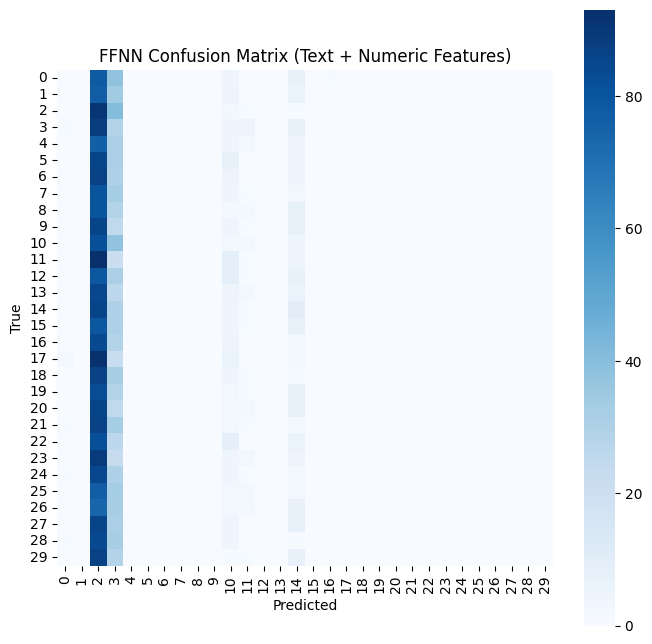

In [12]:
#Classification Report & Confusion Matrix
y_prob = model.predict([X_test_text, X_test_num])
y_pred = np.argmax(y_prob, axis=1)
y_true = np.argmax(y_test, axis=1)   # because y_test is one-hot encoded

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, digits=3, zero_division=0))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 8))
sns.heatmap(cm,
            cmap="Blues",
            cbar=True,
            square=True)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("FFNN Confusion Matrix (Text + Numeric Features)")
plt.show()

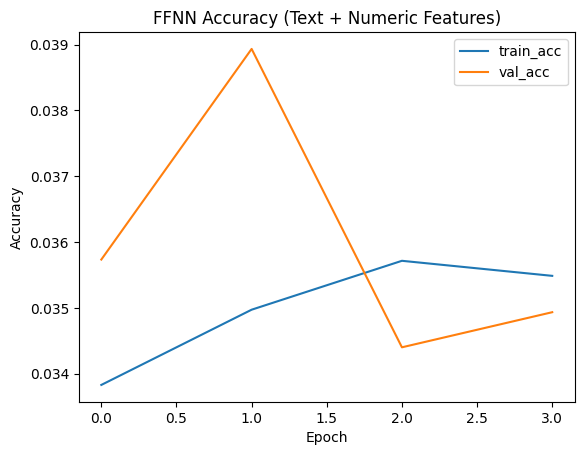

In [13]:
#Training Accuracy Curve
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('FFNN Accuracy (Text + Numeric Features)')
plt.legend()
plt.show()


In [14]:
#Save Model & Preprocessing Tools
model.save("../data/processed/ffnn_model_full.keras")

joblib.dump(tokenizer, "../data/processed/tokenizer.pkl")
joblib.dump(scaler, "../data/processed/numeric_scaler.pkl")
joblib.dump(lb, "../data/processed/label_encoder.pkl")


['../data/processed/label_encoder.pkl']

In [15]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

nltk.download("stopwords")

stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-z\s]", "", text)
    tokens = text.split()
    tokens = [stemmer.stem(w) for w in tokens if w not in stop_words]
    return " ".join(tokens)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rahom\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
#DATA INPUT FOR DEMO#
demo_symptoms = "fever cough headache"
demo_age = 30
demo_symptom_count = 3
demo_gender = "Male"   # Male / Female / Other


In [17]:
#DEMO Encode Numeric Features
gender_map = {"Male": 0, "Female": 1, "Other": 2}
demo_gender_encoded = gender_map[demo_gender]

demo_numeric = np.array([[demo_age, demo_symptom_count, demo_gender_encoded]], dtype=np.float32)
demo_numeric_scaled = scaler.transform(demo_numeric)


In [18]:
#DEMO Tokenize and Pad

demo_clean_symptoms = clean_text(demo_symptoms)

demo_seq = tokenizer.texts_to_sequences([demo_clean_symptoms])
demo_pad = pad_sequences(demo_seq, maxlen=max_len, padding="post")


In [19]:
#DEMO Label index to Disease name mapping

df_raw = pd.read_csv("../data/Healthcare.csv")

label_map = dict(
    enumerate(df_raw["Disease"].astype("category").cat.categories)
)


In [20]:
#Prediction
pred_probs = model.predict([demo_pad, demo_numeric_scaled])

pred_class = np.argmax(pred_probs, axis=1)[0]
pred_label = label_map[pred_class]

print("Input symptoms:", demo_symptoms)
print("Predicted disease:", pred_label)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Input symptoms: fever cough headache
Predicted disease: Dermatitis


In [21]:
#Top-5 Predictions

top_k = 5
probs = pred_probs[0]

top_indices = np.argsort(probs)[-top_k:][::-1]
top_labels = [label_map[i] for i in top_indices]

print("\nTop predictions:")
for label, prob in zip(top_labels, probs[top_indices]):
    print(f"{label}: {prob:.4f}")



Top predictions:
Dermatitis: 0.0346
Anxiety: 0.0345
Depression: 0.0344
Arthritis: 0.0344
Parkinson's: 0.0343
